In [1]:
import csv
import matplotlib.pyplot as plt
import nltk
import pandas
from sklearn.metrics import classification_report, confusion_matrix
from sklearn.model_selection import cross_val_score, cross_val_predict
import numpy as np
from nltk.corpus import stopwords
from nltk.stem import SnowballStemmer
from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier
from sklearn.feature_extraction.text import CountVectorizer, TfidfTransformer
from sklearn.metrics import plot_confusion_matrix, f1_score
from sklearn.model_selection import train_test_split
from sklearn.naive_bayes import MultinomialNB
from sklearn.neighbors import KNeighborsClassifier
from sklearn import svm
from sklearn import tree
from sklearn import metrics

pandas.set_option('display.max_rows', 10000)

# loading the dataset
dataset = pandas.read_csv("training_set.csv",sep=',',usecols=['tweet','label'])
dataset.tweet=dataset.tweet.str.lower()
#print(type(dataset))
#print(f"Number of tweets: {len(dataset)}")
#display(dataset)
#dataset

In [7]:
italian_stemmer = SnowballStemmer('italian')
class StemmedCountVectorizer(CountVectorizer):
    def build_analyzer(self):
        analyzer = super(StemmedCountVectorizer, self).build_analyzer()
        return lambda doc: ([italian_stemmer.stem(w) for w in analyzer(doc)])

In [8]:
X_train, X_test, y_train, y_test = train_test_split(dataset.tweet, dataset.label, test_size=0.3)

In [12]:
#counting the word occurrences,it includes tokenization and stopword filtering, check parameters
count_vect = StemmedCountVectorizer(min_df=3, analyzer="word",ngram_range=(1,2), stop_words = set(stopwords.words('italian')))
#count_vect = CountVectorizer(stop_words=stopwords,analyzer=stemming,min_df=2)

X_train_counts = count_vect.fit_transform(X_train)
#extracted tokens
#print(count_vect.get_feature_names())
  
# Text rapresentation supervised stage on training set, include calculation of TFs (frequencies)
tfidf_transformer = TfidfTransformer(smooth_idf=True, use_idf=True)  
X_train_tfidf = tfidf_transformer.fit_transform(X_train_counts)

# TF-IDF extraction on test set, tokenization and word counting,feature extraction
X_test_counts = count_vect.transform(X_test)
X_test_tfidf = tfidf_transformer.transform(X_test_counts)

In [13]:
def evaluate_classifier(clf):
    clf.fit(X_train_tfidf, y_train)
    #Evaluation on test set
    predicted = clf.predict(X_test_tfidf)#prediction
    #Extracting statistics and metrics
    accuracy=np.mean(predicted == y_test)#accuracy extreaction
    print('accuracy : ' + str(accuracy))

    f_score = f1_score(y_test, predicted, average='macro')
    print('f_score : ' + str(f_score) + '\n')
    
    disp = plot_confusion_matrix(clf, X_test_tfidf, y_test, cmap=plt.cm.Blues, normalize='true')
    disp.ax_.set_title('Confusion Matrix')
    plt.show()

Multinomial NB:
accuracy : 0.5611510791366906
f_score : 0.5626087682882815



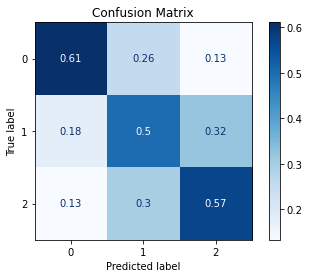

Decision Tree:
accuracy : 0.4172661870503597
f_score : 0.41796559881202117



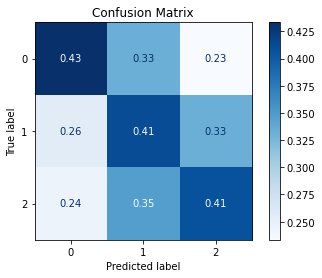

SVM:
accuracy : 0.5071942446043165
f_score : 0.5083548248441865



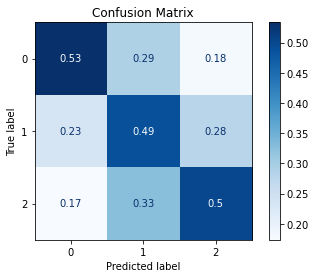

k-NN (k = 5) :
accuracy : 0.5287769784172662
f_score : 0.523828781132926



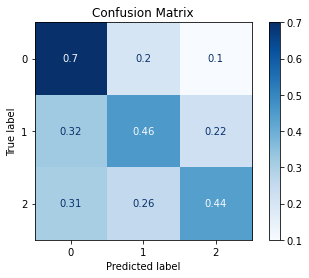

Adaboost:
accuracy : 0.4316546762589928
f_score : 0.4368007077205416



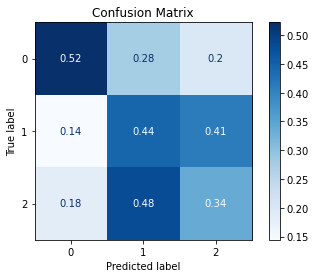

Random Forest:
accuracy : 0.5143884892086331
f_score : 0.5186169317012629



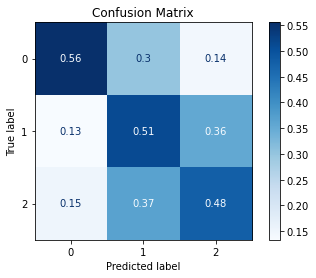

In [14]:
#Training the classifiers

# --------------- BAYESS ---------------
clf1 = MultinomialNB()
print('Multinomial NB:')
evaluate_classifier(clf1)

# --------------- DECISION TREE ---------------
clf2 = tree.DecisionTreeClassifier()
print('Decision Tree:')
evaluate_classifier(clf2)

# --------------- SVC ---------------
clf3 = svm.LinearSVC()
print('SVM:')
evaluate_classifier(clf3)

# --------------- K-NN ---------------
k_neighbor = 5
clf4 = KNeighborsClassifier(k_neighbor)
print('k-NN (k = ' + str(k_neighbor) + ') :')
evaluate_classifier(clf4)

# --------------- ADABOOST ---------------
clf5 = AdaBoostClassifier()
print('Adaboost:')
evaluate_classifier(clf5)

# --------------- RANDOM FOREST ---------------
clf6 = RandomForestClassifier()
print('Random Forest:')
evaluate_classifier(clf6)